In [ ]:
import os
import imghdr
from zipfile import ZipFile as zip_file

<ipython-input-1-70e708d27743>:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [ ]:
!wget http://105.105.52.117:8080/imgs.zip -O /content/imgs.zip

--2025-04-30 19:54:07--  http://105.105.52.117:8080/imgs.zip
Connecting to 105.105.52.117:8080... connected.
HTTP request sent, awaiting response... 200 OK
Length: 811113230 (774M) [application/zip]
Saving to: ‘/content/imgs.zip’

/content/imgs.zip   100%[===================>] 773.54M   638KB/s    in 31m 1s  

2025-04-30 20:25:08 (426 KB/s) - ‘/content/imgs.zip’ saved [811113230/811113230]



In [ ]:
!mv /content/imgs.zip /content/drive/MyDrive/'Colab Notebooks'/nsfw_data

## cleaning data

In [ ]:
root_dir = '/content/drive/MyDrive/Colab Notebooks/nsfw_data/imgs.zip'
image_exts = ['jpeg', 'jpg', 'bmp', 'png', 'webp']

In [ ]:
with zip_file(root_dir, 'r') as zip:
  zip.extractall(os.getcwd())

In [ ]:
data_dir = '/content/imgs'

In [ ]:
for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir, image_class)):
    image_path = os.path.join(data_dir, image_class, image)
    try:
      tip = imghdr.what(image_path)
      if tip not in image_exts:
        print("Image Not in exts: ", image_path)
        os.remove(image_path)
    except Exception as e:
      print('issue with image {}'.format(image_path))


Image Not in exts:  /content/imgs/sexy/New-Sexy-Underwear-Steel-Bowknot-Bikini-Sexy-Hollow-Three-Po.webp
Image Not in exts:  /content/imgs/sexy/50356.jpg
Image Not in exts:  /content/imgs/sexy/52000979480_1d156f859f.jpg
Image Not in exts:  /content/imgs/sexy/medium-hot-sexy-176-bwa-b-d-146-original-imaerg47t74h2fuz.jpeg
Image Not in exts:  /content/imgs/sexy/278154-nice-hot-sexy (copy 1).jpg
Image Not in exts:  /content/imgs/sexy/278154-nice-hot-sexy.jpg
Image Not in exts:  /content/imgs/sexy/image.jpg
Image Not in exts:  /content/imgs/sexy/High-Quality-Women-Sexy-100-Lace-3-Piece-Set-Women-Lingerie.webp


In [ ]:
len(os.listdir(os.path.join(data_dir, 'sexy')))

3378

In [ ]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
device

'cuda'

In [ ]:
image_path = []
labels = []

for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir, image_class)):
    image_path.append(os.path.join(data_dir, image_class, image))
    labels.append(image_class)

In [ ]:
labels[12000]

'sexy'

In [ ]:
data_df = pd.DataFrame({'image_path': image_path, 'labels': labels})

In [ ]:
data_df.head()

,image_path,labels
0,/content/imgs/normal/dog.84.jpg,normal
1,/content/imgs/normal/test_image_png_2072.png,normal
2,/content/imgs/normal/images (172).jpeg,normal
3,/content/imgs/normal/test_image_png_3478.png,normal
4,/content/imgs/normal/test_image_png_932.png,normal


In [ ]:
len(data_df)

13658

In [ ]:
data_df['labels'].unique()

array(['normal', 'sexy'], dtype=object)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test  = train_test_split(data_df['image_path'], data_df['labels'], test_size=0.2, random_state=42)

In [ ]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [ ]:
X_train.shape

(10926,)

In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(data_df['labels'])

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # Normalize input
])

In [ ]:
class CustomImageDataset(Dataset):
  def __init__(self, image_path, labels, transform=None):
    self.image_path = image_path
    self.labels = torch.tensor(label_encoder.transform(labels))
    self.transform = transform

  def __len__(self):
    return len(self.image_path)

  def __getitem__(self, idx):
    img_path = self.image_path.iloc[idx]
    label = self.labels[idx]
    image = Image.open(img_path).convert("RGB")

    if self.transform:
      image = self.transform(image).to(device)

    return image, label

In [ ]:
train_dataset = CustomImageDataset(X_train, y_train, transform=transform)
val_dataset = CustomImageDataset(X_val, y_val, transform=transform)
test_dataset = CustomImageDataset(X_test, y_test, transform=transform)

In [ ]:
train_dataset.__getitem__(1020)

(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]], device='cuda:0'),
 tensor(0))

In [ ]:
label_encoder.inverse_transform([0])

array(['normal'], dtype=object)

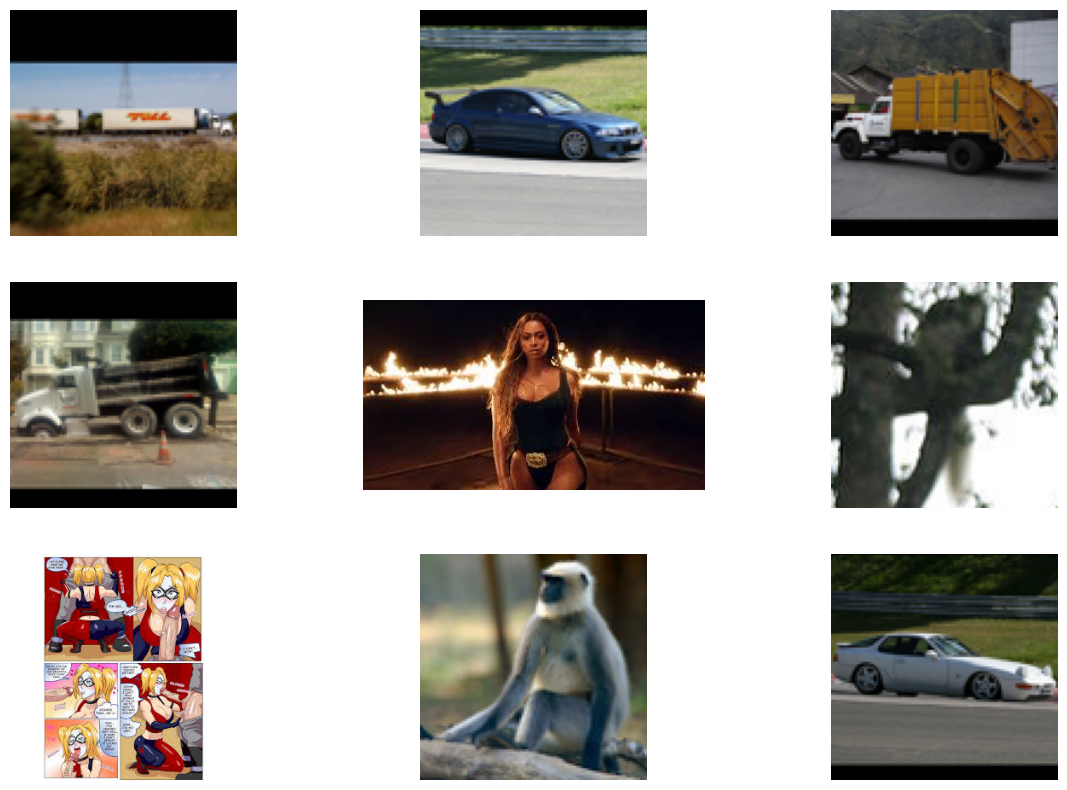

In [ ]:
import random
n_rows = 3
n_cols = 3

fig, axis = plt.subplots(n_rows, n_cols, figsize=(15, 10))

for row in range(n_rows):
  for col in range(n_cols):
    image = Image.open(data_df.iloc[random.randrange(0, len(data_df)), 0]).convert("RGB")
    axis[row, col].imshow(image)
    axis[row, col].axis('off')
plt.show()

In [ ]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 30

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
first = next(iter(train_loader))

In [ ]:
# first

In [ ]:
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
class NeuralNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

    self.pooling = nn.MaxPool2d(2, 2)
    self.batch_norm1 = nn.BatchNorm2d(32)
    self.batch_norm2 = nn.BatchNorm2d(64)
    self.batch_norm3 = nn.BatchNorm2d(128)

    self.dropout = nn.Dropout(0.5) # Dropout for regularization


    self.flatten = nn.Flatten()
    self.linear = nn.Linear((128*16*16), 128)
    self.output = nn.Linear(128, len(data_df['labels'].unique()))

  def forward(self, x):
    x = self.conv1(x)
    x = self.batch_norm1(x)
    x = F.relu(x)
    x = self.pooling(x)

    x = self.conv2(x)
    x = self.batch_norm2(x)
    x = F.relu(x)
    x = self.pooling(x)

    x = self.conv3(x)
    x = self.batch_norm3(x)
    x = F.relu(x)
    x = self.pooling(x)

    x = self.flatten(x)
    x = self.linear(x)
    x = self.dropout(x)
    x = self.output(x)

    return x

In [ ]:
model = NeuralNet().to(device)

In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
       BatchNorm2d-2         [-1, 32, 128, 128]              64
         MaxPool2d-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
       BatchNorm2d-5           [-1, 64, 64, 64]             128
         MaxPool2d-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
       BatchNorm2d-8          [-1, 128, 32, 32]             256
         MaxPool2d-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
          Dropout-12                  [-1, 128]               0
           Linear-13                    [-1, 2]             258
Total params: 4,288,386
Trainable param

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [ ]:
total_loss_train_plot = []
total_loss_val_plot = []
total_acc_train_plot = []
total_acc_val_plot = []

In [ ]:
for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
  total_loss_val = 0
  total_acc_val = 0

  for inputs, labels in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs)
    sm = nn.Softmax(dim=1)
    softmax1 = sm(outputs)
    labels = labels.to(device)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
    total_acc_train += train_acc

    optimizer.step()

  with torch.no_grad():
    for inputs, labels in val_loader:
      outputs = model(inputs)
      sm2 = nn.Softmax(dim=1)
      softmax2 = sm2(outputs)
      labels = labels.to(device)
      val_loss = criterion(outputs, labels)
      total_loss_val += val_loss.item()
      val_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
      total_acc_val += val_acc
  total_loss_train_plot.append(round(total_loss_train / 1000, 4))
  total_loss_val_plot.append(round(total_loss_val / 1000, 4))
  total_acc_train_plot.append(round(total_acc_train/train_dataset.__len__(), 4))
  total_acc_val_plot.append(round(total_acc_val/val_dataset.__len__(), 4))

  print(f'''Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train / 1000, 4)}, Train Accuracy {round(total_acc_train/train_dataset.__len__(), 4)}
                                    , Train Soft: {softmax1}
                                    , Validation Loss: {round(total_loss_val / 1000, 4)}, Vaalidation Accuracy {round(total_acc_val/val_dataset.__len__(), 4)}
                                    , Validation Soft: {softmax2}
        ''')

Epoch 1/30, Train Loss: 0.4241, Train Accuracy 0.8395
                                    , Train Soft: tensor([[9.9997e-01, 2.5817e-05],
        [3.7063e-02, 9.6294e-01],
        [7.6182e-01, 2.3818e-01],
        [1.0000e+00, 7.2364e-07],
        [9.9930e-01, 6.9853e-04],
        [9.9990e-01, 9.7092e-05],
        [1.0000e+00, 6.5563e-07],
        [9.8145e-01, 1.8547e-02],
        [2.3452e-01, 7.6548e-01],
        [1.0000e+00, 4.6159e-07],
        [9.1888e-01, 8.1123e-02],
        [9.8112e-01, 1.8883e-02],
        [1.0000e+00, 3.9802e-08],
        [8.9638e-02, 9.1036e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
                                    , Validation Loss: 0.0337, Vaalidation Accuracy 0.8851
                                    , Validation Soft: tensor([[9.9991e-01, 9.3925e-05],
        [9.9996e-01, 4.0959e-05],
        [9.9892e-01, 1.0829e-03],
        [9.9578e-01, 4.2236e-03],
        [9.9994e-01, 5.6329e-05],
        [9.9803e-01, 1.9715e-03]], device='cuda:0')
      

In [ ]:
test_pred = []
test_labels = []
with torch.inference_mode():
  for inputs, labels in test_loader:
    outputs = model(inputs)
    test_pred.extend(torch.argmax(outputs, axis=1).cpu().numpy())
    test_labels.extend(labels.cpu().numpy())
correct_predictions = np.sum(np.array(test_pred) == np.array(test_labels))

print(f"Correct Predictions: {correct_predictions}")
print(f"Total Test Samples: {len(test_labels)}")
print(f"Accuracy: {correct_predictions / len(test_labels)}")


Correct Predictions: 1318
Total Test Samples: 1366
Accuracy: 0.9648609077598829


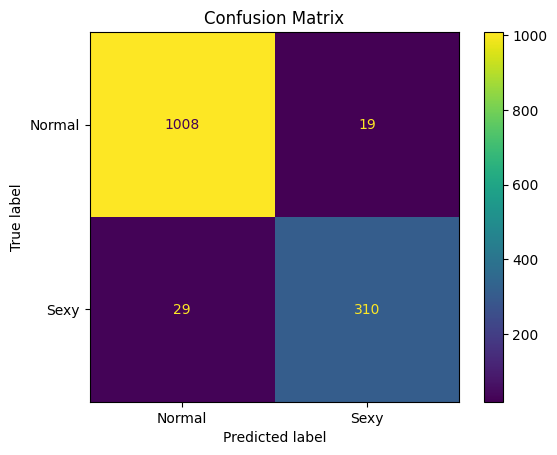

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_labels, test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Sexy"])
disp.plot()
plt.title("Confusion Matrix")
plt.show()

In [ ]:


torch.save(model.state_dict(), "model.pt")

In [ ]:
!pip install datasets transformers

In [ ]:
from datasets import load_dataset
from transformers import Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.model_selection import train_test_split

In [ ]:
# 1. Load the dataset
dataset = load_dataset('csv', data_files={'train': '/content/drive/MyDrive/Colab Notebooks/nsfw_data/muslim_safe_unsafe_dataset_mixed.csv'}, delimiter=',')

# 2. Load the model and tokenizer
model_name = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2) # Binary classification (0 or 1)
tokenizer = AutoTokenizer.from_pretrained(model_name)


# 3. Preprocess the data (tokenization)
def preprocess_function(examples):
  return tokenizer(examples['text'], truncation=True, padding=True, max_length=128)

Generating train split: 0 examples [00:00, ? examples/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [ ]:
dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
import random

train_size = int(len(dataset['train']) * 0.8)
val_size = len(dataset['train']) - train_size

train_indices = random.sample(range(len(dataset['train'])), train_size)
val_indices = list(set(range(len(dataset['train']))) - set(train_indices))

In [ ]:
train_indices

[53,
 152,
 487,
 197,
 456,
 211,
 196,
 445,
 261,
 432,
 23,
 275,
 310,
 417,
 270,
 347,
 169,
 168,
 357,
 159,
 290,
 215,
 385,
 164,
 423,
 58,
 156,
 216,
 4,
 467,
 376,
 272,
 396,
 229,
 17,
 426,
 166,
 303,
 350,
 370,
 382,
 137,
 488,
 476,
 35,
 271,
 333,
 276,
 411,
 112,
 379,
 173,
 64,
 298,
 52,
 86,
 220,
 5,
 93,
 420,
 9,
 485,
 402,
 403,
 451,
 217,
 221,
 97,
 248,
 205,
 258,
 80,
 44,
 470,
 10,
 46,
 181,
 96,
 468,
 73,
 434,
 246,
 279,
 6,
 210,
 208,
 401,
 400,
 140,
 268,
 486,
 25,
 76,
 282,
 491,
 263,
 324,
 21,
 60,
 447,
 234,
 371,
 380,
 415,
 364,
 95,
 453,
 274,
 308,
 83,
 353,
 277,
 1,
 224,
 214,
 165,
 319,
 48,
 359,
 321,
 260,
 103,
 351,
 356,
 294,
 495,
 94,
 101,
 381,
 267,
 184,
 413,
 440,
 315,
 29,
 438,
 366,
 232,
 43,
 316,
 349,
 100,
 68,
 338,
 121,
 71,
 81,
 446,
 288,
 442,
 406,
 409,
 163,
 89,
 459,
 151,
 266,
 307,
 314,
 286,
 404,
 377,
 189,
 419,
 265,
 37,
 278,
 193,
 26,
 388,
 383,
 465,
 99,
 346,

In [ ]:
train_dataset = dataset['train'].select(train_indices)
val_dataset = dataset['train'].select(val_indices)

In [ ]:
# 5. Training arguments
training_args = TrainingArguments(
    output_dir='./results',         # where to save the model checkpoints
    num_train_epochs=30,             # number of epochs to train
    per_device_train_batch_size=16, # batch size for training
    per_device_eval_batch_size=64,  # batch size for evaluation
    warmup_steps=500,               # number of warmup steps
    weight_decay=0.01,              # strength of weight decay
    logging_dir='./logs',           # directory for storing logs
    logging_steps=10,
)

In [ ]:
# 6. Trainer for fine-tuning
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
)

<ipython-input-67-97d44a19c62b>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# 7. Start training
trainer.train()

Step,Training Loss
10,0.505500
20,0.486900
30,0.465000
40,0.436700
50,0.400400
60,0.351800
70,0.292100
80,0.244300
90,0.189300
100,0.142300


TrainOutput(global_step=750, training_loss=0.05652467543507616, metrics={'train_runtime': 75.2002, 'train_samples_per_second': 159.574, 'train_steps_per_second': 9.973, 'total_flos': 21614489568000.0, 'train_loss': 0.05652467543507616, 'epoch': 30.0})

In [ ]:
model.save_pretrained("fine_tuned_model")

In [ ]:
!mv /content/fine_tuned_model /content/drive/MyDrive/'Colab Notebooks'/nsfw_data

In [ ]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 101.0 MB/s eta 0:00:00


In [ ]:
# Convert model to onnx format
from transformers import AutoModelForSequenceClassification
import torch
import onnx


# Load the trained model
model_path = '/content/drive/MyDrive/Colab Notebooks/nsfw_data/fine_tuned_model'
model = AutoModelForSequenceClassification.from_pretrained(model_path)
# Set the model to evaluation model
model.eval()

# create a dummy input

dummy_input = torch.ones(1, 128).long()

# Export the model to ONNX
onnx_output_path = "/content/drive/MyDrive/Colab Notebooks/nsfw_data/fine_tuned_model.onnx"
torch.onnx.export(model, dummy_input, onnx_output_path, input_names=['input_ids'], output_names=['logits'])
print(f'ONNX model saved to {onnx_output_path}')

ONNX model saved to /content/drive/MyDrive/Colab Notebooks/nsfw_data/fine_tuned_model.onnx


In [ ]:
# Convert my cnn model to onnx

model_path = '/content/model.pt'

model = NeuralNet()

model.load_state_dict(torch.load(model_path))



model.eval()

# Create dummy input matching your CNN input size, e.g., 3x224x224 image
dummy_input = torch.randn(1, 3, 128, 128)

# Export to ONNX
torch.onnx.export(model, dummy_input, "cnn_model.onnx",
                  input_names=['input'], output_names=['output'])